# Full Workflow {.unnumbered} 

## Packages

In [3]:
import sys
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rio
import json
import numpy as np
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('scripts')))

# from scripts.config import *
from scripts.utils import create_cube_subset, create_paths
from scripts.s03_base_analysis import base_analysis, change_plot, plot_timeseries
from scripts.config import variables
from scripts.modelling_functions import plot_multiple_results;
import matplotlib.pyplot as plt

# Write data to disk set to False
write_data = False


def plot_multiple_results(results_dict, time_index = None):
    num_plots = len(results_dict)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(17, num_rows * 7))
    if num_rows * num_cols > 1:
        axes = axes.flatten()  # Flatten the axes array for easier iteration
    else:
        axes = [axes]  # Ensure axes is iterable

    for i, (lat_lon, data_dict) in enumerate(results_dict.items()):
        ax = axes[i]

        testY = data_dict['results']['true_values']
        forecasts = data_dict['results']['predicted_values']
        mae = data_dict['evaluation']['mae']
        rmse = data_dict['evaluation']['rmse']

        # Assuming lat_lon keys are in the format "(lat, lon)" and need to be converted from string
        lat, lon = eval(lat_lon)  # Convert the string key back to tuple if necessary

        # Generate a time index from the length of the testY data
        # time_index = range(len(testY))

        ax.plot(time_index, testY, label="Actual")
        ax.plot(time_index, forecasts, label="Predicted")
        ax.set_title(f"Lat: {lat}, Lon: {lon}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

        # Add MSE to the corner
        ax.text(0.95, 0.05, f"RMSE: {rmse:.2f}, MAE: {mae:.2f}", 
                verticalalignment='bottom', horizontalalignment='right', 
                transform=ax.transAxes, color='red', fontsize=12)

    # Adjust the layout to prevent overlap and make sure all plots are visible
    plt.tight_layout()
    plt.show()


2024-07-28 18:22:12.914030: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 18:22:12.916380: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 18:22:12.951885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 18:22:13.936631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Setup 

First we setup the data path and use create_paths() from utils to create paths necessary throughout the analysis.

Second we use create_subset() to create a subset of the Earth System Data Cube, croped to:

- our AOI, the extent of germany 
- the time span where the SIF variable is avaialble 
- to the relevant variables

[More Information](#sec-utils)

In [4]:
# Create a data directory
data_path = "data"
os.makedirs(data_path, exist_ok=True)

# Create paths to the data
germany_shp_path, corine_file_path, cube_sample_path, cube_crop_path, cube_crop_mask_path = create_paths(data_path=data_path)

# Create a subset of the Earth System Data Cube, containing only relevant variables and the desired spatial and temporal extent
cube_subset = create_cube_subset()

# remove attributes
cube_subset.attrs = {}

print(cube_subset)

<xarray.Dataset> Size: 30MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
    spatial_ref             int64 8B 0
Data variables:
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4

## Downloading auxillary data

The first part of the analysis is to download and preprocess all the necassaty auxillary data:

- download german border shapefile
- download and preprocess Corine data (for the forest mask) and use the border data to define the AOI
- create sif sample tif for spatial resolution and transform (used later to resample corine data)

[More Information](#sec-load_aux)

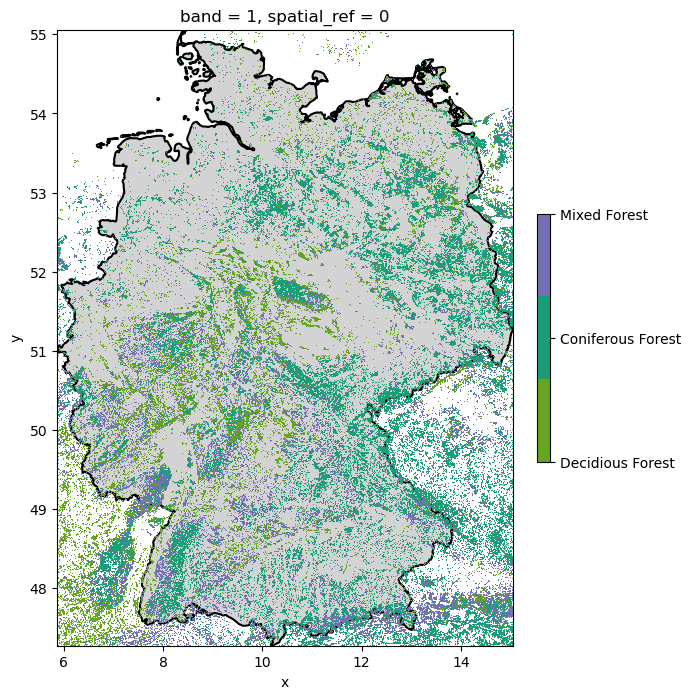

In [4]:
# Load the germany border shapefile
germany_gpd = gpd.read_file(germany_shp_path)

# Load the CORINE land cover data
corine_raster = rio.open_rasterio(corine_file_path)

# set 0 to na
corine_raster = corine_raster.where(corine_raster != 0)

cmap = ListedColormap(['#66a61e', '#1b9e77', '#7570b3'])
vmin = 311; vmax = 313
legend_labels=['Decidious Forest', 'Coniferous Forest', 'Mixed Forest']


# Plot the CORINE land cover data with the Germany border overlayed
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Germany with gray fill and black boundary
germany_gpd.plot(ax=ax, color='lightgray', edgecolor='black', alpha=1, linewidth=1.5)

# Plot rasterio dataset
corine_raster.plot(ax=ax, alpha=1, vmin=vmin, vmax=vmax, cmap= cmap, add_colorbar=False)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
                    ax=ax, fraction=0.02, pad=0.04)

ticks = np.linspace(vmin, vmax, len(legend_labels))
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(legend_labels)

plt.show()


## Preprocessing the cube 

Next we want to preprocess our data cube. 

This includes:

- croping the cube with the german border shape
 
- masking the cube with the corine forest cover:
   
  - Calculate the forest percentage of the Corine landcover data over the cube grid
  - add the forest percentages to the cube
  - add a binary forest cover layer to the cube (0 for <50% forest cover, 1 for >=50% forest cover)
  - use the layer to mask the cube

The results are cube_subset_crop which is croped with the germany border and cube_subset_mask, masked with the forest cover.

[More Information](#sec-cube_preproc)

***

**Visualization of Corine Data Processing.**

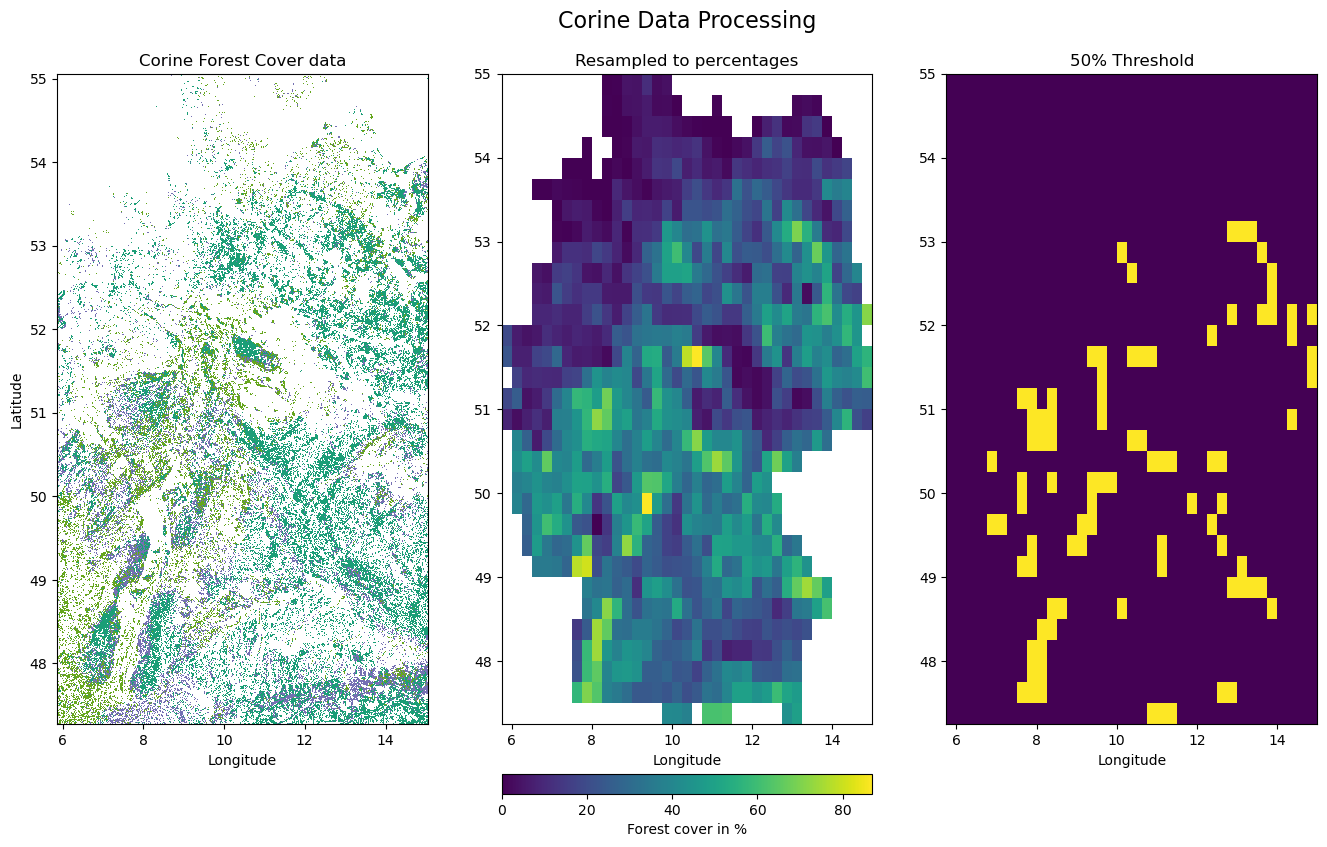

In [32]:
# Load cube subset croped and cube subset mask
cube_subset_crop = xr.open_dataset(cube_crop_path)
cube_subset_mask = xr.open_dataset(cube_crop_mask_path)

# Load the forest percentages raster
forest_percentages = rio.open_rasterio(cube_crop_path.replace(".nc", "_percentages.tif"))

# Create a grid spec with extra space at the bottom
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 3, height_ratios=[1, 0.03], hspace=0.15)

# Create subplots in the grid spec
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# Plot rasterio dataset
corine_raster.plot(ax=ax0, alpha=1, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
ax0.set_title("Corine Forest Cover data")
ax0.set_ylabel("Latitude")
ax0.set_xlabel("Longitude")

# Plot the forest percentages raster
forest_im = forest_percentages.plot(ax=ax1, alpha=1, add_colorbar=False)
ax1.set_title("Resampled to percentages")
ax1.set_ylabel("")
ax1.set_xlabel("Longitude")

# Add a colorbar at the bottom for the forest percentages raster
cax = fig.add_subplot(gs[1, 1])  # Add a subplot in the second row, middle column
cbar = fig.colorbar(forest_im, cax=cax, orientation='horizontal')
cbar.set_label("Forest cover in %")

# Plot the forest cover 50% threshold
cube_subset_crop.forest_cover_50.plot(ax=ax2, vmin=0, add_colorbar=False)
ax2.set_title("50% Threshold")
ax2.set_ylabel("")
ax2.set_xlabel("Longitude")

# Main title for the entire figure
fig.suptitle("Corine Data Processing", fontsize=16)

# Adjust the layout to ensure everything fits well
plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0)
plt.show()



***

**Showing croped and masked + croped cube**

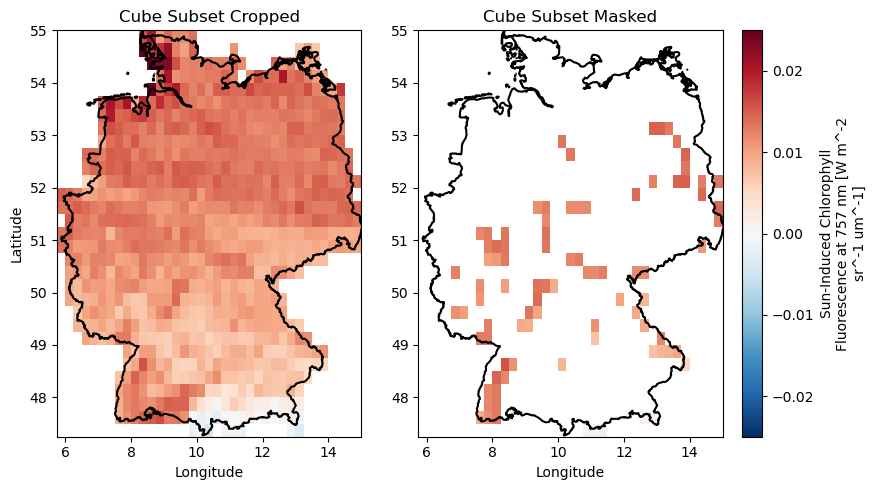

In [24]:



# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


# Plot the croped dataset
im = cube_subset_crop.sif_gosif.isel(time=0).plot(ax=axes[0], add_colorbar=False, vmin = -0.025, vmax = 0.025, cmap='RdBu_r')
axes[0].set_title("Cube Subset Cropped")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Plot the masked dataset
cube_subset_mask.sif_gosif.isel(time=0).plot(ax=axes[1], add_colorbar=True, vmin = -0.025, vmax = 0.025, cmap='RdBu_r')
axes[1].set_title("Cube Subset Masked")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("")

# Add germany border
germany_gpd.plot(ax=axes[0], edgecolor='black', alpha=1, linewidth=1.5, facecolor = "none")
germany_gpd.plot(ax=axes[1], edgecolor='black', alpha=1, linewidth=1.5, facecolor = "none" )

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust rect to make room for the colorbar
plt.show()



## Basic Analysis of SIF-Data

The following part will
  
- Perform a change detection by calculating the summer mean for each year and the change for the year 2018 to the baseline up to 2017
  
- Resulting Plots:
  - Time-Series of SIF, considering only cells with more than 50% forest cover in 2000
  - Difference SIF 2018 to mean of 2002 - 2017 over all cells in germany 


***

**Plot summer means for the SIF variable for the reference period 2000-2017, 2018 and the difference of them.**

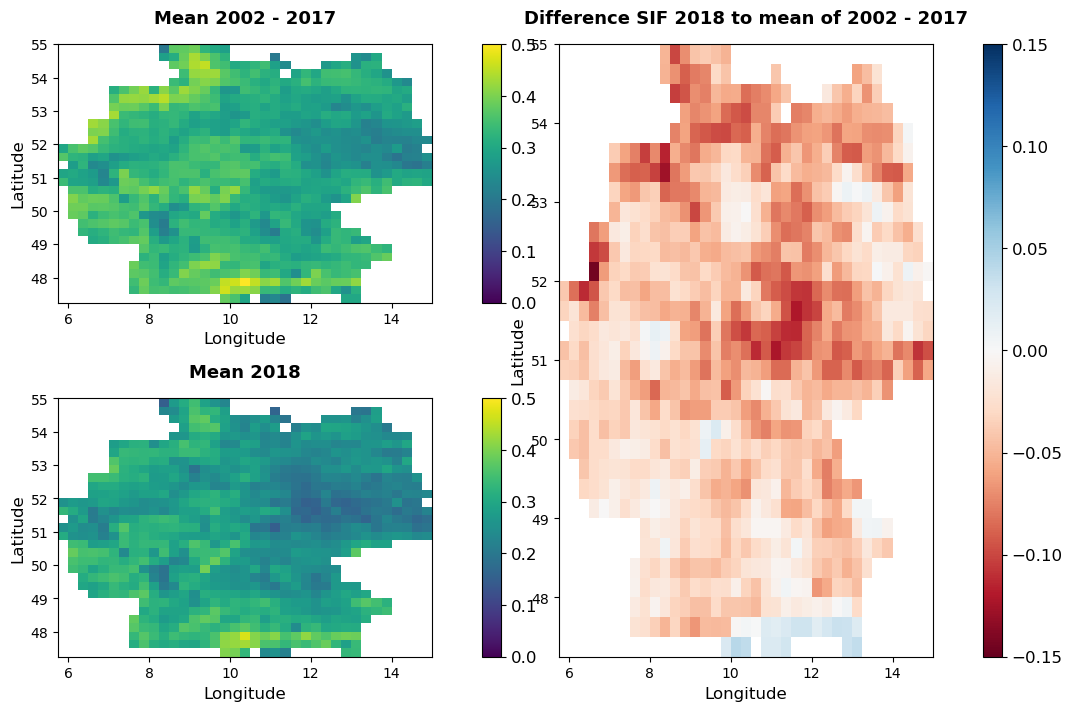

In [33]:
# Calculate the temporal changes in the variables 
summer_sif_mean_cube, summer_mean_to_2017, changes = base_analysis(cube_subset_crop, years=[2018, 2019])


# Calculate the summer mean for each year and the change compared to the baseline up to 2017
summer_mean_cube, summer_mean_to_2017, changes = base_analysis(cube_subset_crop, years=[2018, 2019])

# Select only year 2018
summer_mean_2018 = summer_sif_mean_cube.sel(year=2018)

change_plot(ref_period = summer_mean_to_2017, data_2018 = summer_mean_2018, changes = changes);

*** 

**Plot Sif Time series (mean over masked cells in germany)**

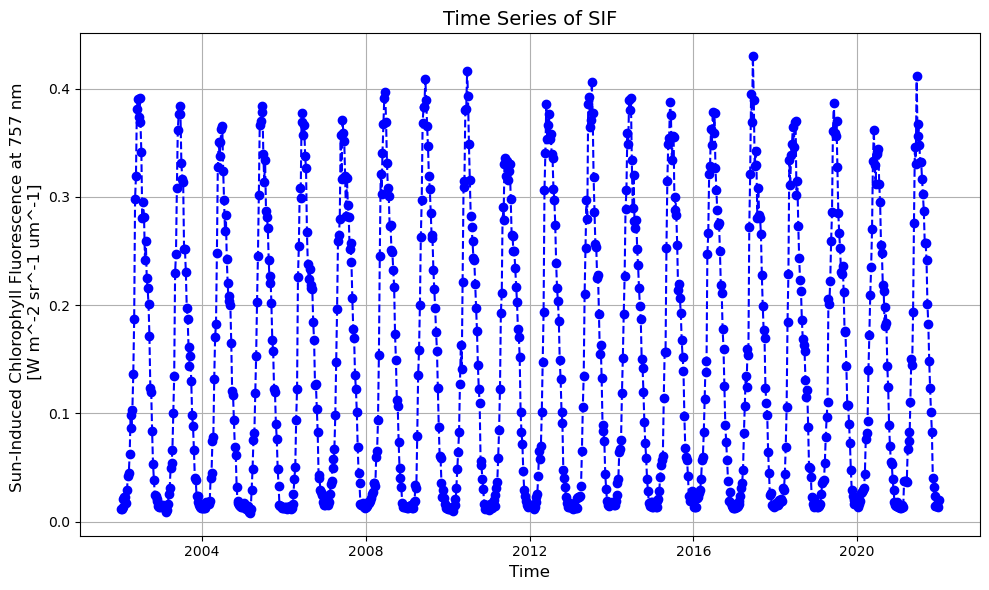

In [35]:
# Save plot of timeseries:
plot_timeseries(cube_subset_mask, save_path = os.path.join("results", "figures", "timeseries_full.png"))
# plot_timeseries(cube_subset_mask, time_range= ["2015-01-01", "2022-12-31"], save_path = os.path.join("results", "figures", "timeseries_recent.png"))

## Prelimnary Modelling

To determine what is the appropriate model structure, we tested for different approaches.

Four general model setups were tested, which are differing whether they are global or local models and whether they have an auto regressive component or not, meaning whether they encoperate a shifted version of target variable as a predictor.

To find the best hyperparameters 3 look back periods were tested and a grid search cross-validation was done.

[More Information](#-src_prelim)

*** 

**Table showing mae and rmse model performances**

In [139]:
import os
import json
from collections import defaultdict

# Function to read JSON files and extract relevant data
def read_json_files(base_dir):
    # Initialize a dictionary to store the extracted data
    results = {
        "results_l15": {"auto": [], "noauto": []},
        "results_l30": {"auto": [], "noauto": [], "global_auto": [], "global_noauto": []},
        "results_l45": {"auto": [], "noauto": []},
    }

    # Traverse through the base directory and subdirectories
    for lookback_dir in ["results_l15", "results_l30", "results_l45"]:
        lookback_path = os.path.join(base_dir, lookback_dir)
        if not os.path.isdir(lookback_path):
            continue

        # Identify files containing "auto", "noauto", or "global" in their names
        for filename in os.listdir(lookback_path):
            if "global" in filename:
                continue

            if "noauto" in filename:
                key = "noauto"
            elif "auto" in filename:
                key = "auto"
            else:
                continue

            file_path = os.path.join(lookback_path, filename)

            # Read and parse the JSON file
            with open(file_path, 'r') as file:
                data = json.load(file)

                # Extract relevant data and store it in the results dictionary
                for location, details in data.items():
                    result_entry = {
                        "location": location,
                        "best_params": details.get("best_params", {}),
                        "look_back": details.get("look_back", 0),
                        "evaluation": details.get("evaluation", {}),
                    }
                    results[lookback_dir][key].append(result_entry)

    return results

# Function to calculate mean performance metrics
def calculate_mean_performance(results):
    # Initialize dictionaries to store the sum and count of performance metrics
    performance_sums = defaultdict(lambda: {"mae": 0, "rmse": 0, "count": 0})
    mean_performance = {}

    # Sum the performance metrics and count the number of entries
    for lookback in results:
        for auto_type in results[lookback]:
            for entry in results[lookback][auto_type]:
                evaluation = entry["evaluation"]
                if "mae" in evaluation and "rmse" in evaluation:
                    performance_sums[f"{lookback}_{auto_type}"]["mae"] += evaluation["mae"]
                    performance_sums[f"{lookback}_{auto_type}"]["rmse"] += evaluation["rmse"]
                    performance_sums[f"{lookback}_{auto_type}"]["count"] += 1

    # Calculate the mean performance metrics
    for key, sums in performance_sums.items():
        if sums["count"] > 0:
            mean_performance[key] = {
                "mean_mae": np.round(sums["mae"] / sums["count"], 4),
                "mean_rmse": np.round(sums["rmse"] / sums["count"], 4)
            }
        else:
            mean_performance[key] = {"mean_mae": None, "mean_rmse": None}

    return mean_performance

# Base directory where the results folders are located
base_dir = os.path.join("results", "modelling")

# Read JSON files and extract data
results_data = read_json_files(base_dir)

# Calculate mean performance metrics
mean_performance_data = calculate_mean_performance(results_data)


globa_auto_path = os.path.join(base_dir, "results_l30", "results_global_auto_l30.json")
global_noauto_path = os.path.join(base_dir, "results_l30", "results_global_noauto_l30.json")

def get_mae_rmse_from_json(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return np.round(data["evaluation"]["mae"],3), np.round(data["evaluation"]["rmse"],3)

global_results = get_mae_rmse_from_json(globa_auto_path), get_mae_rmse_from_json(global_noauto_path)

import pandas as pd
# Convert the dictionary to a DataFrame
data = []
for key, values in mean_performance_data.items():
    lookback, auto_type = key.rsplit('_', 1)
    data.append({
        'model' : 'local',
        'lookback': lookback[-2:],
        'type': auto_type,
        'mean_mae': values['mean_mae'],
        'mean_rmse': values['mean_rmse']
    })

# Add global results to the data
data.append({
    'model' : 'global',
    'lookback': '30',
    'type': 'auto',
    'mean_mae': global_results[0][0],
    'mean_rmse': global_results[0][1]
})
data.append({
    'model' : 'global',
    'lookback': '30',
    'type': 'noauto',
    'mean_mae': global_results[1][0],
    'mean_rmse': global_results[1][1]
})

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

    model lookback    type  mean_mae  mean_rmse
0   local       15    auto    0.0150     0.0217
1   local       15  noauto    0.0161     0.0228
2   local       30    auto    0.0144     0.0212
3   local       30  noauto    0.0142     0.0210
4   local       45    auto    0.0149     0.0218
5   local       45  noauto    0.0145     0.0211
6  global       30    auto    0.0330     0.0450
7  global       30  noauto    0.0330     0.0500


*** 

**Comparison between local models.**

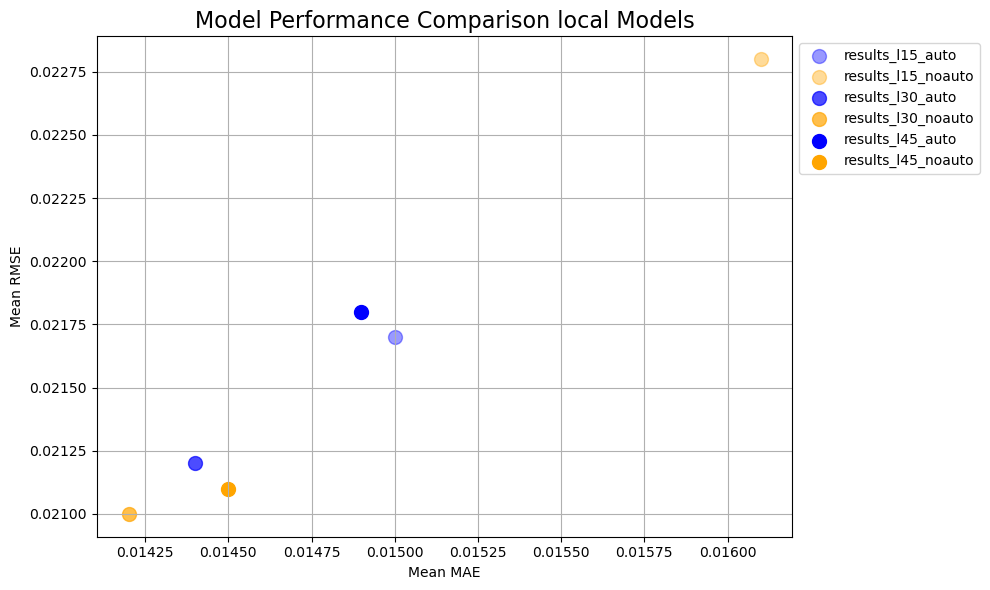

In [141]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_performance_data(mean_performance_data):
    # Define colors and markers
    colors = {
        'auto': "blue",
        'noauto': "orange"
    }
    shades = {
        'results_l15': 0.4,
        'results_l30': 0.7,
        'results_l45': 1
    }
    markers = ['o', 's', 'D', '^']

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot data for each key in the mean performance data
    for idx, (key, performance) in enumerate(mean_performance_data.items()):
        lookback, auto_type = key.rsplit('_', 1)
        color = colors[auto_type]
        shade = shades[lookback]

        plt.scatter(performance['mean_mae'], performance['mean_rmse'], 
                    color=color, alpha=shade, label=key, s=100)



    # Add labels and title
    plt.xlabel('Mean MAE')
    plt.ylabel('Mean RMSE')
    plt.title('Model Performance Comparison local Models', fontsize=16)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

# Call the function to plot the data
plot_performance_data(mean_performance_data)


## Modelling results

Based on the prelimary results a local model with a lookback of 30 time steps (30 * 8 days = 240 days) was chosen.

Apart from that the modelling setup was the same, except that the number of hyperparameters was reduced based on the prelimary results.

In [85]:
# Reading the results and evaluation from the file
with open("results/modelling/final/results_full_local_auto_l30.json", 'r') as file:
    results_dict = json.load(file)

rmse_values = {loc: data['evaluation']['rmse'] for loc, data in results_dict.items()}

# Find locations with highest and lowest RMSE
highest_rmse_location = max(rmse_values, key=rmse_values.get)
lowest_rmse_location = min(rmse_values, key=rmse_values.get)


print(f'Location with highest RMSE: {highest_rmse_location}, RMSE: {rmse_values[highest_rmse_location]:.3f}')
print(f'Location with lowest RMSE: {lowest_rmse_location}, RMSE: {rmse_values[lowest_rmse_location]:.3f}')

# Extracting true and predicted values for these locations
true_values_high_rmse = results_dict[highest_rmse_location]['results']['true_values']
predicted_values_high_rmse = results_dict[highest_rmse_location]['results']['predicted_values']
true_values_low_rmse = results_dict[lowest_rmse_location]['results']['true_values']
predicted_values_low_rmse = results_dict[lowest_rmse_location]['results']['predicted_values']

# scores for the locations
rmse_high = results_dict[highest_rmse_location]['evaluation']['rmse']
mae_high = results_dict[highest_rmse_location]['evaluation']['mae']
rmse_low = results_dict[lowest_rmse_location]['evaluation']['rmse']
mae_low = results_dict[lowest_rmse_location]['evaluation']['mae']

# mean errors
mean_rmse = np.mean([data['evaluation']['rmse'] for data in results_dict.values()])
mean_mae = np.mean([data['evaluation']['mae'] for data in results_dict.values()])

print(f'Mean MAE: {mean_mae:.3f}, Mean RMSE: {mean_rmse:.3f}')

# print the mean errors


Location with highest RMSE: (52.625, 10.375), RMSE: 0.031
Location with lowest RMSE: (52.125, 13.875), RMSE: 0.013
Mean MAE: 0.014, Mean RMSE: 0.020


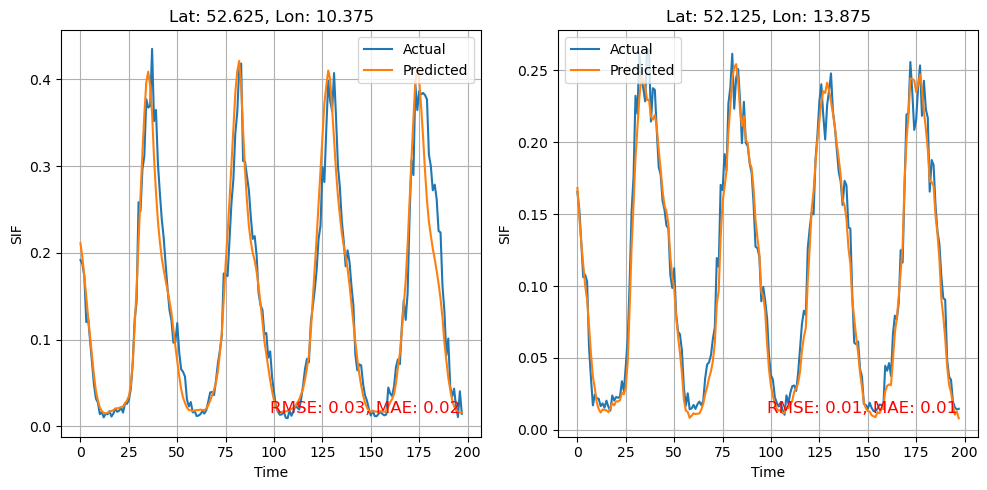

In [55]:

def plot_multiple_results(results_dict, keys_to_plot=None, time_index=None):
    # If no specific keys are provided, plot all entries in the dictionary
    if keys_to_plot is None:
        keys_to_plot = list(results_dict.keys())
    
    num_plots = len(keys_to_plot)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 5))
    if num_rows * num_cols > 1:
        axes = axes.flatten()  # Flatten the axes array for easier iteration
    else:
        axes = [axes]  # Ensure axes is iterable

    for i, lat_lon in enumerate(keys_to_plot):
        ax = axes[i]
        data_dict = results_dict[lat_lon]
        testY = data_dict['results']['true_values']
        forecasts = data_dict['results']['predicted_values']
        mae = data_dict['evaluation']['mae']
        rmse = data_dict['evaluation']['rmse']

        # Assuming lat_lon keys are in the format "(lat, lon)" and need to be converted from string
        lat, lon = eval(lat_lon)  # Convert the string key back to tuple if necessary

        # Generate a time index from the length of the testY data if not provided
        if time_index is None:
            time_index = range(len(testY))

        ax.plot(time_index, testY, label="Actual")
        ax.plot(time_index, forecasts, label="Predicted")
        ax.set_title(f"Lat: {lat}, Lon: {lon}")
        ax.set_xlabel("Time")
        ax.set_ylabel("SIF")
        ax.legend()
        ax.grid(True)

        # Add RMSE and MAE to the corner
        ax.text(0.95, 0.05, f"RMSE: {rmse:.2f}, MAE: {mae:.2f}", 
                verticalalignment='bottom', horizontalalignment='right', 
                transform=ax.transAxes, color='red', fontsize=12)

    # Adjust the layout to prevent overlap and make sure all plots are visible
    plt.tight_layout()
    plt.show()



plot_multiple_results(results_dict, keys_to_plot=[highest_rmse_location, lowest_rmse_location])


In [53]:

# Extract RMSEs and corresponding locations
rmse_values = {loc: data['evaluation']['rmse'] for loc, data in results_dict.items()}

# Sort locations by RMSE
sorted_locations = sorted(rmse_values, key=rmse_values.get)

# Find two locations with highest and two with lowest RMSE
lowest_rmse_locations = sorted_locations[:2]
highest_rmse_locations = sorted_locations[-2:]

location_dict = {
    'Highest RMSE Locations': lowest_rmse_locations,
    'Lowest RMSE Locations': highest_rmse_locations
}


In [167]:
import matplotlib.pyplot as plt

def plot_forecasts_from_dict(results_dict):
    """
    This function takes a dictionary containing model results and creates plots for the two locations
    with the highest and two locations with the lowest RMSE values.

    Args:
    results_dict (dict): Dictionary containing model results with true and predicted values.

    Returns:
    None
    """
    # Extract RMSEs and corresponding locations
    rmse_values = {loc: data['evaluation']['rmse'] for loc, data in results_dict.items()}

    # Sort locations by RMSE
    sorted_locations = sorted(rmse_values, key=rmse_values.get)

    # Find two locations with highest and two with lowest RMSE
    lowest_rmse_locations = sorted_locations[:2]
    highest_rmse_locations = sorted_locations[-2:]

    # Function to plot true vs predicted values
    def plot_forecast(true_values, predicted_values, title, ax):
        line1, = ax.plot(true_values, label='True Values', color='blue', linewidth=2)
        line2, = ax.plot(predicted_values, label='Predicted Values', color='red', linestyle='--', linewidth=2)
        ax.set_title(title, fontsize=14, y = 1.05)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('SIF', fontsize=12)
        ax.grid(True)
        return line1, line2


    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Plot for locations with lowest RMSE
    lines = []
    for i, loc in enumerate(lowest_rmse_locations):
        true_values = results_dict[loc]['results']['true_values']
        predicted_values = results_dict[loc]['results']['predicted_values']
        line1, line2 = plot_forecast(
            [val[0] for val in true_values],
            [val[0] for val in predicted_values],
            f'Lowest (best) RMSE predictions',
            ax=axs[0, i]
        )
        lines.append((line1, line2))

    # Plot for locations with highest RMSE
    for i, loc in enumerate(highest_rmse_locations):
        true_values = results_dict[loc]['results']['true_values']
        predicted_values = results_dict[loc]['results']['predicted_values']
        line1, line2 = plot_forecast(
            [val[0] for val in true_values],
            [val[0] for val in predicted_values],
            f'Highest (worst) RMSE predictions',
            ax=axs[1, i]
        )
        lines.append((line1, line2))

    # Add a main title
    fig.suptitle('Forecasted vs True Values', fontsize=16, y=0.95)



    # Add a single shared legend
    #fig.legend([lines[0][0], lines[0][1]], ['True Values', 'Predicted Values'], loc='lower center', fontsize=12)
    fig.legend([lines[0][0], lines[0][1]], ['True Values', 'Predicted Values'], loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=2,
               fontsize = 14)

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    plt.show()

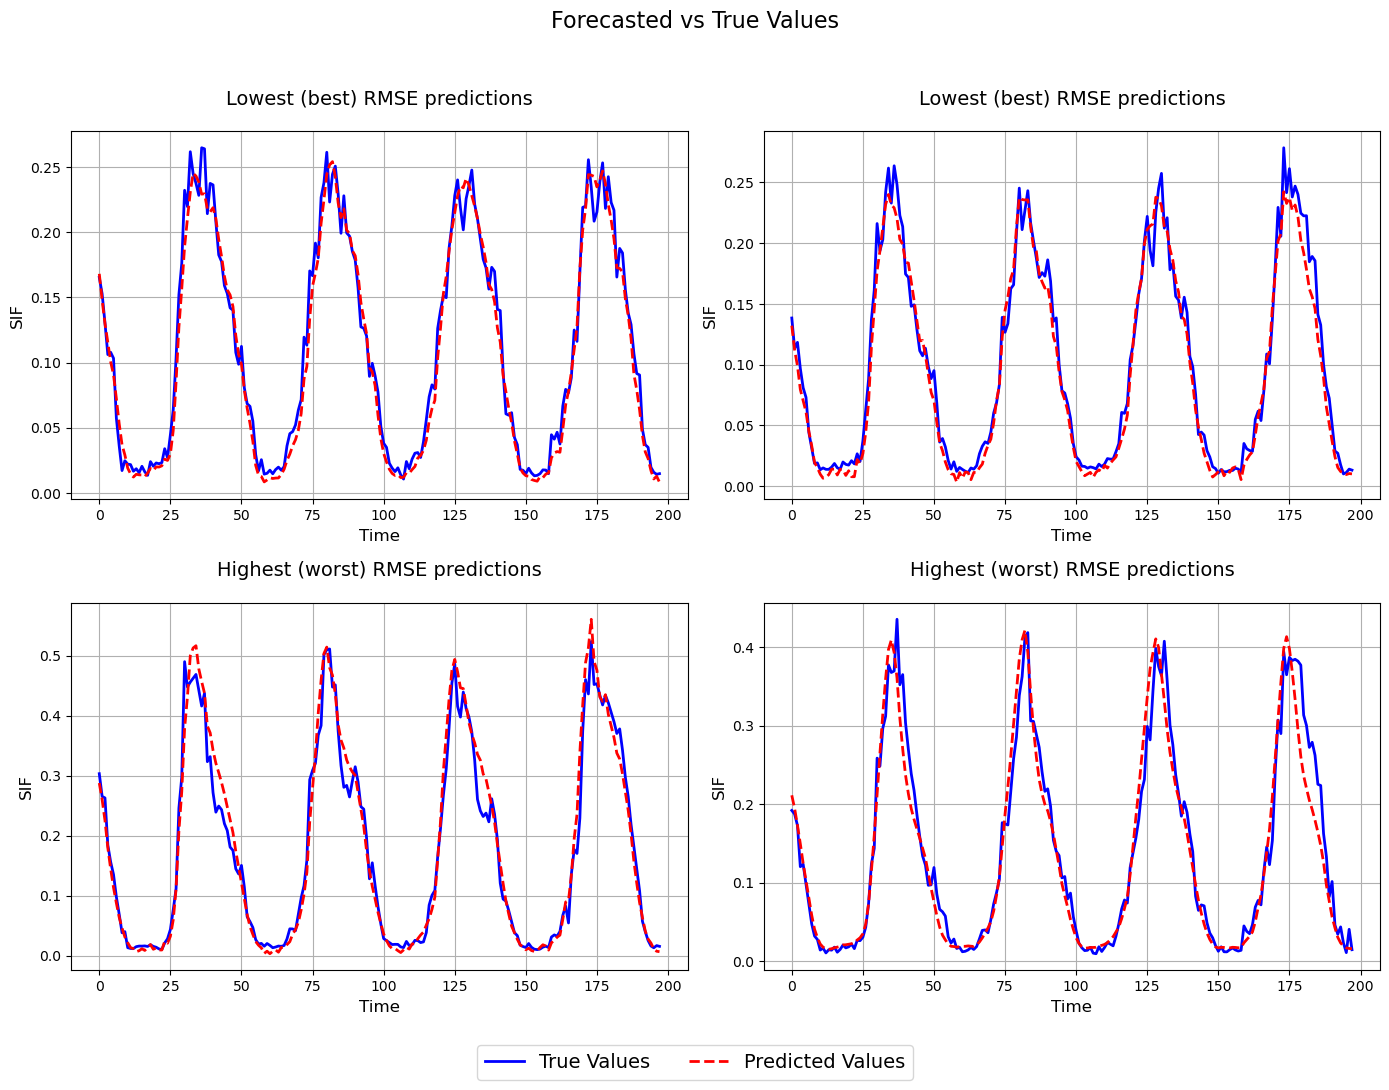

In [168]:
# Call the function with the example dictionary
plot_forecasts_from_dict(results_dict)
